**1) GET DATA SOURCE**

In [42]:
import os
import tarfile
import urllib

In [43]:
root = "https://github.com/ageron/handson-ml/raw/master/"
Housing_Path = os.path.join("datasets", "housing")
URL = root + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=URL, housing_path=Housing_Path):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [44]:
fetch_housing_data()

In [45]:
import pandas as pd

def load_housing_data(housing_path=Housing_Path):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [46]:
housing_data = load_housing_data()
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


**2) SPLIT THE DATA USING STRATIFIED SHUFFLING STRATEGY ON MEDIAN_INCOME** 

**Need to convert the median_income numerical column to categorical**

<AxesSubplot:>

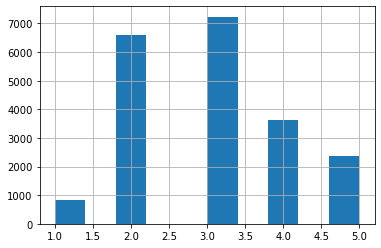

In [47]:
import numpy as np

housing_data['income_cat'] = np.ceil(housing_data['median_income'] / 1.5)
da=housing_data['income_cat'].where(housing_data['income_cat'] < 5, 5.0, inplace=True)

housing_data['income_cat'].hist()

**use sklearn to stratified split the data on median_income**

In [48]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing_data, housing_data['income_cat']):
    strat_train_set = housing_data.loc[train_index]
    strat_test_set = housing_data.loc[test_index]

In [49]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,2.0
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,5.0
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,2.0
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,2.0
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN,3.0


**PREPARE DATASET FOR ML ALGORITHMS**

Remove the target attribute column from the training set to build a model without knowing the target attribute.

In [50]:
housing = strat_train_set.drop("median_house_value", axis=1)
house_labels = strat_train_set["median_house_value"].copy() # this is our y

check to see if there are any missing values.

In [51]:
na_rows = housing[housing.isnull().any(axis=1)].head()
na_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN,2.0
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN,4.0
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN,4.0
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND,2.0
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN,3.0


**use sklearn pipeline to transform the data**

In [52]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer



In [53]:
imputer = SimpleImputer(strategy="median") # this line will handle missing values but will only work on numerical attributes
housing_num = housing.drop('ocean_proximity', axis=1) # this line removes the text attribute and will be converted to numerical using OneHotEncoder
cat_encoder = OneHotEncoder()

In [54]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

In [55]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [56]:
housing_prepared # this is my X

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [57]:
housing_prepared.shape

(16512, 14)

In [58]:
house_labels

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
           ...   
6563     240200.0
12053    113000.0
13908     97800.0
11159    225900.0
15775    500001.0
Name: median_house_value, Length: 16512, dtype: float64

**SELECT AND TRAIN THE DATASET** Linear Regression

In [59]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, house_labels)

LinearRegression()

In [60]:
#preprocess pipeline on a few training instances(row)
some_data = housing.iloc[:5]
some_labels = house_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [205841.96139906 329060.05217695 205219.96047357  61859.01340291
 196908.23636333]


In [61]:
# COMPARE THE MEDIUM HOUSE VALUES PREDICTED FROM THE MODEL TO THE ACTUAL VALUES IN THE TRAINING SET

In [62]:
from sklearn.metrics import mean_squared_error

housing_prediction = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(house_labels, housing_prediction)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68867.01067610044

^ this model does not fit the training data much. This linear reg is not a good learning model for data. Go to another model before going to the next step.UNDERFITTING

**NEW MODEL: Decision TREE** non-linear model

In [63]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, house_labels)

DecisionTreeRegressor(random_state=42)

In [64]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(house_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

zero means there is no error. This is not good. this model only predicted the values you already have. called OVERFITTING- it does not generalize well

**NEW MODEL: Random Forest (multiple decisiontree)**

In [27]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, house_labels)

RandomForestRegressor(n_estimators=10, random_state=42)

In [28]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(house_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21806.001308325463

**NEW MODEL: SUPPORT VECTOR REGRESSION**

In [38]:
from sklearn.svm import SVR

support_reg = svm.SVR(kernel="linear")
support_reg.fit(housing_prepared, house_labels)

SVR(kernel='linear')

In [39]:
housing_predictions = support_reg.predict(housing_prepared)
support_mse = mean_squared_error(house_labels, housing_predictions)
support_rmse = np.sqrt(support_mse)
support_rmse

107334.94039494894

**NEW MODEL: Neural Networks**

In [35]:
from sklearn.neural_network import MLPRegressor

neural_reg = MLPRegressor(hidden_layer_sizes=(64,64,64),activation="relu" ,random_state=1, max_iter=2000)
neural_reg.fit(housing_prepared, house_labels)

MLPRegressor(hidden_layer_sizes=(64, 64, 64), max_iter=2000, random_state=1)

In [36]:
housing_predictions = neural_reg.predict(housing_prepared)
neural_mse = mean_squared_error(house_labels, housing_predictions)
neural_rmse = np.sqrt(neural_mse)
neural_rmse

50272.3728292725

**CROSS-VALIDATION**

In [68]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [69]:
from sklearn.model_selection import cross_val_score

In [70]:
forest_scores = cross_val_score(forest_reg, housing_prepared, house_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [50129.0317713  48872.9062692  52692.96728922 52687.29981628
 51654.64852665 56141.02302783 50839.51920779 53412.41229007
 53717.04926031 52156.81807666]
Mean: 52230.36755353126
Standard deviation: 1930.8791648660251


this code is for the training data that fits well.

**WE NEED TO FINE TUNE THE MODEL** after choosing the best model

In [73]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, house_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [74]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, house_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001DBE76BD310>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001DBE76CC5E0>},
                   random_state=42, scoring='neg_mean_squared_error')

**APPLY THE TEST DATA**

In [75]:
final_model1 = grid_search.best_estimator_
final_model2 = rnd_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions1 = final_model1.predict(X_test_prepared)
final_predictions2 = final_model2.predict(X_test_prepared)

final_mse1 = mean_squared_error(y_test, final_predictions1)
final_rmse1 = np.sqrt(final_mse1)
print(final_rmse1)

final_mse2 = mean_squared_error(y_test, final_predictions2)
final_rmse2 = np.sqrt(final_mse2)
print(final_rmse2)

48474.605007937585
47695.183073825414


In [81]:
import joblib
joblib.dump(final_model1, "final_model1.pkl") 
my_model_loaded = joblib.load("final_model1.pkl")